<a href="https://colab.research.google.com/github/BhekiMabheka/Data_Driven_Competions/blob/master/Predicting_Earthquake_Damage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

Based on aspects of building location and construction, the goal is to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal.



The data was collected through surveys by [Kathmandu Living Labs](https://http://www.kathmandulivinglabs.org/) and the [Central Bureau of Statistics](https://**https**://cbs.gov.np/), which works under the National Planning Commission Secretariat of Nepal. This survey is **one of the largest post-disaster datasets ever collected**, containing valuable information on earthquake impacts, household conditions, and socio-economic-demographic statistics.

---

We're trying to predict the [ordinal variable](https://https://web.ma.utexas.edu/users/mks/statmistakes/ordinal.html) `damage_grade`, which represents a level of damage to the building that was hit by the earthquake. There are 3 grades of the damage:

- 1 represents low damage
- 2 represents a medium amount of damage
- 3 represents almost complete destruction

In [23]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? Y


In [0]:
# Data Wrangling/Visualization Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
import warnings 
warnings.filterwarnings(action = "ignore")

# Machine Learning Packages from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.externals import joblib

#### Load and prepare the data set

In [25]:
# Predictors(Independent  Variables)
train_values_df = pd.read_csv("https://raw.githubusercontent.com/BhekiMabheka/Data/master/earthquake_train_values.csv")
print("NUM OF OBSERVATIONS: ",train_values_df.shape[0])
print("NUM OF FEATURES    : ",train_values_df.shape[1])
train_values_df.head(3)

NUM OF OBSERVATIONS:  260601
NUM OF FEATURES    :  39


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [26]:
train_labels = pd.read_csv("https://raw.githubusercontent.com/BhekiMabheka/Data/master/earthquake_train_labels.csv")
print("NUM OF OBSERVATIONS: ",train_labels.shape[0])
print("NUM OF FEATURES    : ",train_labels.shape[1])
train_labels["damage_grade"] = train_labels.damage_grade.map({1: "LOW_DAMAGE",
                                                              2: "MEDIUM_DAMAGE",
                                                              3: "FULL_DAMAGE"})
train_labels.head(3)

NUM OF OBSERVATIONS:  260601
NUM OF FEATURES    :  2


,building_id,damage_grade
0,802906,FULL_DAMAGE
1,28830,MEDIUM_DAMAGE
2,94947,FULL_DAMAGE


We now use the `building_id` to merge the two abouve dataframes. We will use this dataframe as the training set.

In [27]:
train_df = pd.merge(left = train_values_df, left_on = ["building_id"], right = train_labels, right_on = ["building_id"])
train_df.head(3)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,FULL_DAMAGE
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,MEDIUM_DAMAGE
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,FULL_DAMAGE


#### Examine classes and class imbalance

Class imbalance means that there are unequal numbers of cases for the categories of the label. Class imbalance can seriously bias the training of classifier algorithms. It many cases, the imbalance leads to a higher error rate for the minority class. Most real-world classification problems have class imbalance, sometimes severe class imbalance, so it is important to test for this before training any model.

Class imbalance can be sovled by various sampling techniques such as [stratified sampling](https://https://en.wikipedia.org/wiki/Stratified_sampling), [Synthetic Minority Over-sampling](https://https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html#r001eabbe5dd7-1), [SVMSMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SVMSMOTE.html#imblearn.over_sampling.SVMSMOTE) etc. Imbalance have a big impact on the model metric evaluation; more especially if you're trying to optimize accuracy!

MEDIUM_DAMAGE    0.57
FULL_DAMAGE      0.33
LOW_DAMAGE       0.10
Name: damage_grade, dtype: float64


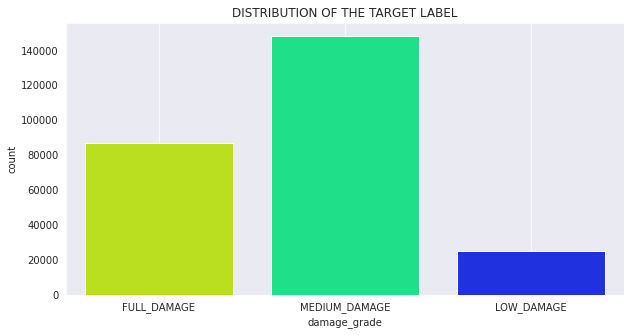

In [28]:
plt.figure(figsize = (10,5))
sns.countplot(train_df.damage_grade, palette = ("gist_rainbow"));
print(np.round(train_df.damage_grade.value_counts(normalize=True), 2))
plt.title(label = "DISTRIBUTION OF THE TARGET LABEL");
plt.grid();

There is 10% of low damage, 33% of full damage and 57% medium damage. However in terms of sampling methods we have a fairly balance proportion. This is open for discussion!

In [29]:
def check_missing(df):
  missing_df =  pd.DataFrame(data = df.isnull().sum(), columns = ['MUM_OF_MISSING'])
  data_types =  pd.DataFrame(df.dtypes, columns = ["DATA_TYPES"])
  percent    =  pd.DataFrame(data = df.isnull().sum()/ df.isnull().count(), columns = ["MISSING_VALUES_IN_%"])
  check_df   =  pd.concat([data_types, missing_df, percent], axis = 1).sort_values(by = 'MUM_OF_MISSING', ascending = False)
  return check_df

# Invoke(call) the function
check_missing(df = train_df)

,DATA_TYPES,MUM_OF_MISSING,MISSING_VALUES_IN_%
building_id,int64,0,0.0
geo_level_1_id,int64,0,0.0
has_superstructure_bamboo,int64,0,0.0
has_superstructure_rc_non_engineered,int64,0,0.0
has_superstructure_rc_engineered,int64,0,0.0
has_superstructure_other,int64,0,0.0
legal_ownership_status,object,0,0.0
count_families,int64,0,0.0
has_secondary_use,int64,0,0.0
has_secondary_use_agriculture,int64,0,0.0


We have no missing values, this is actually quite good for modelling.

## Visualize class separation by numeric features

The primary goal of visualization for classification problems is to understand which features are useful for class separation.

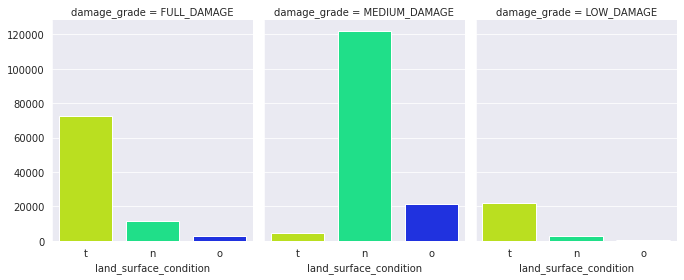

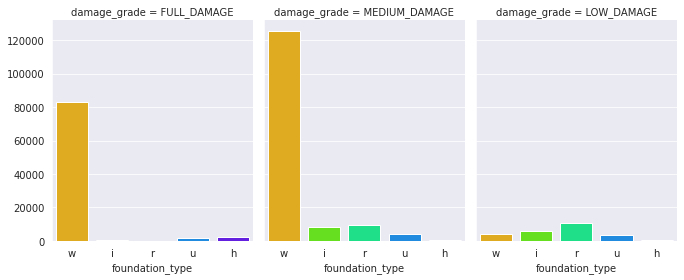

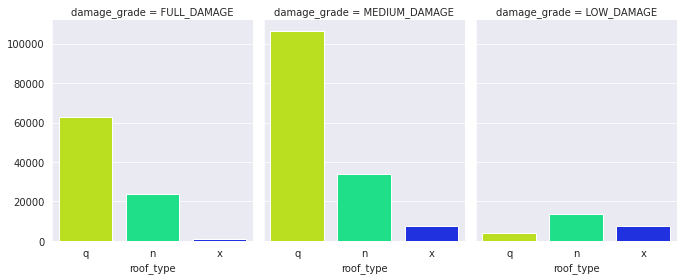

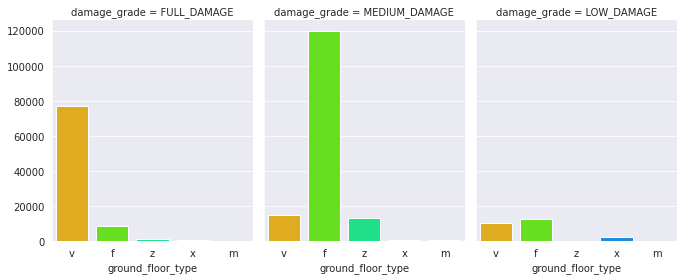

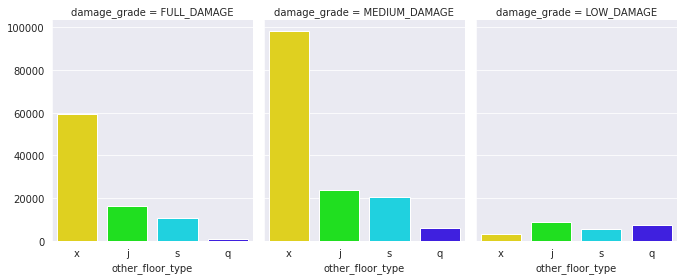

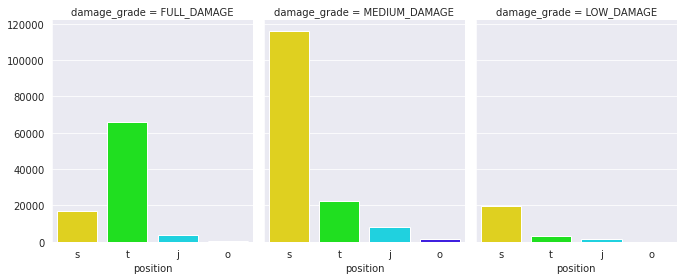

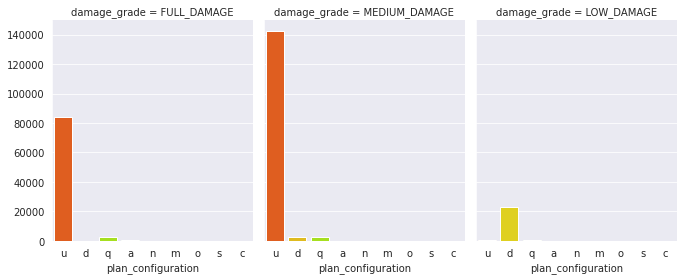

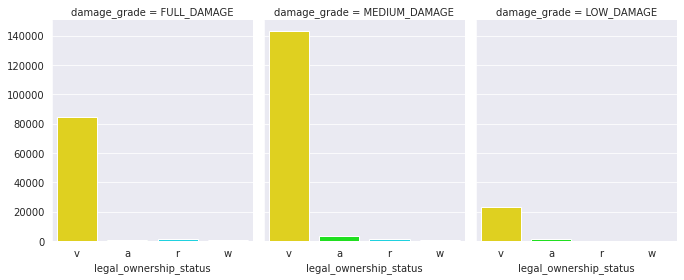

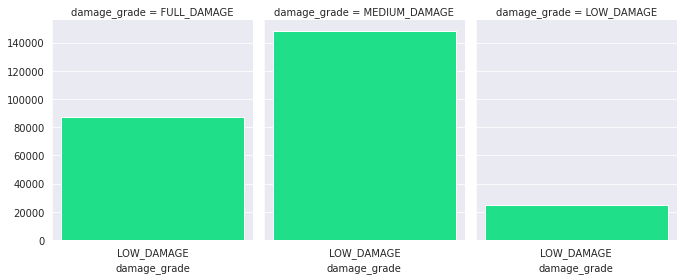

In [30]:
def countplot(df, target_label):
    """
    df: Pandas DataFrame
    target_label: numpy ndarray or Pandas Series
    """
    cols = df.columns.tolist()
    for col in cols:
      sns.set_style("darkgrid")
      if( df[col].dtypes in [np.object] ):
        g = sns.FacetGrid(data = df, col = target_label, height = 4, aspect = .8)
        g.map(sns.countplot, col, palette = ("gist_rainbow"))

# Call the function
countplot(df = train_df, target_label = "damage_grade");

I will put some comments for the above graphs...

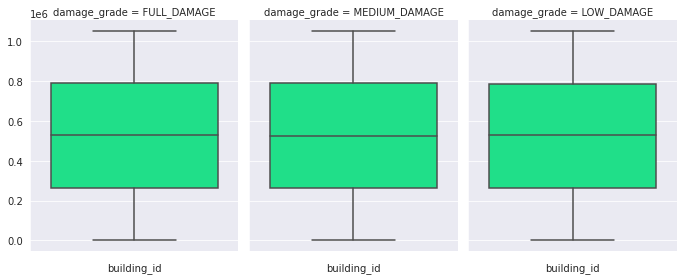

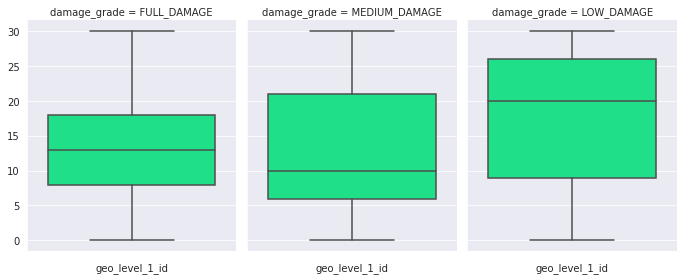

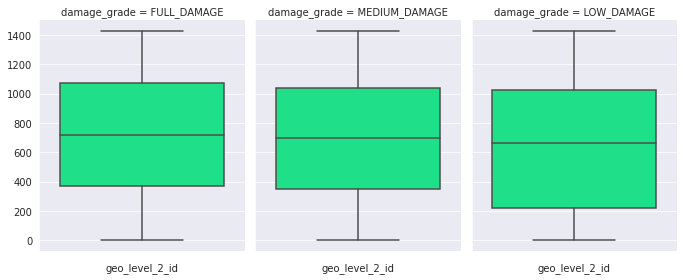

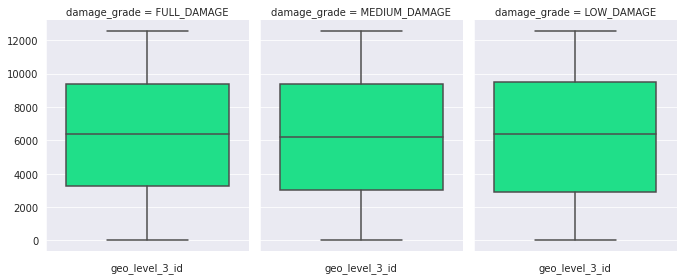

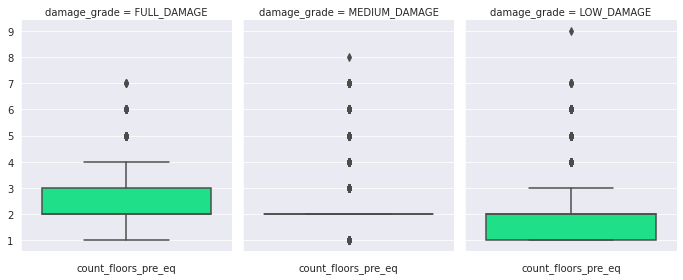

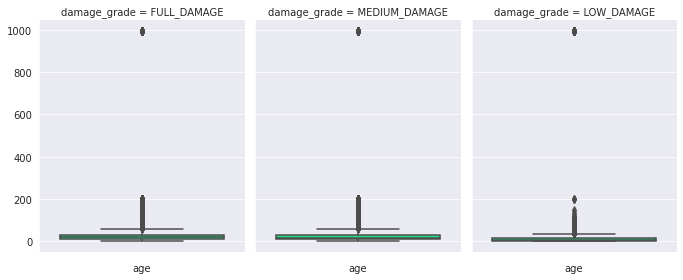

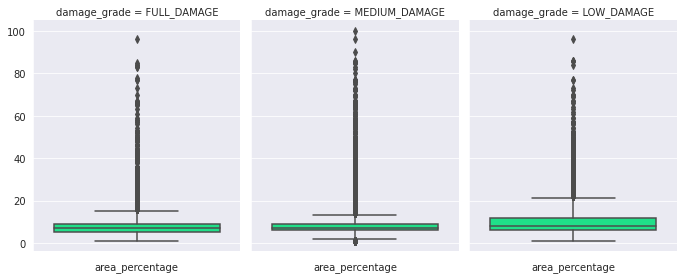

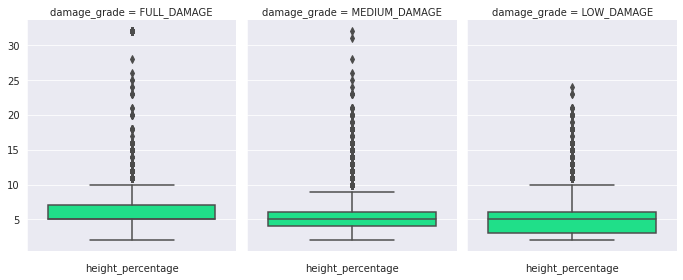

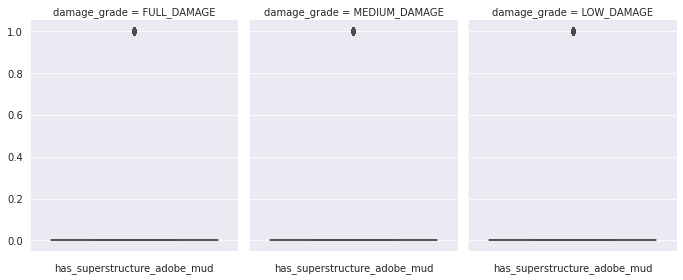

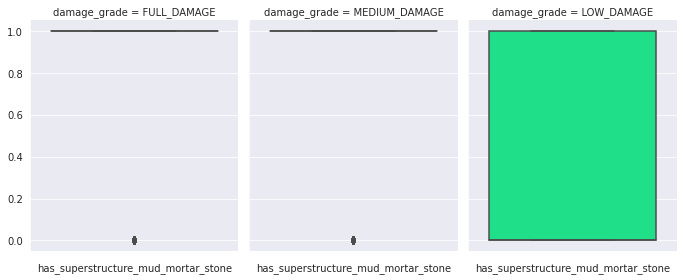

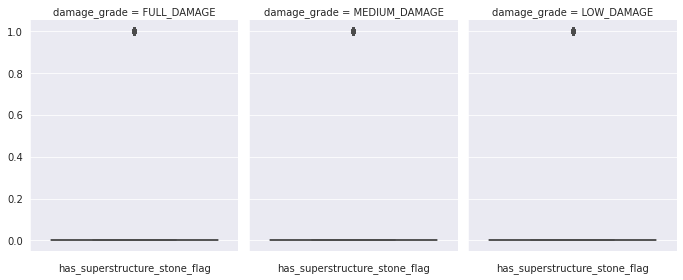

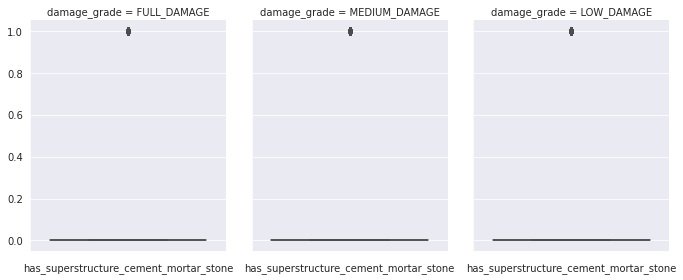

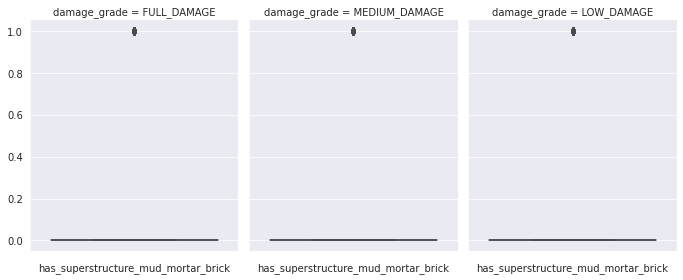

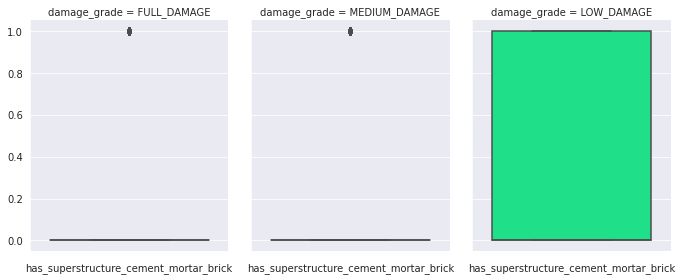

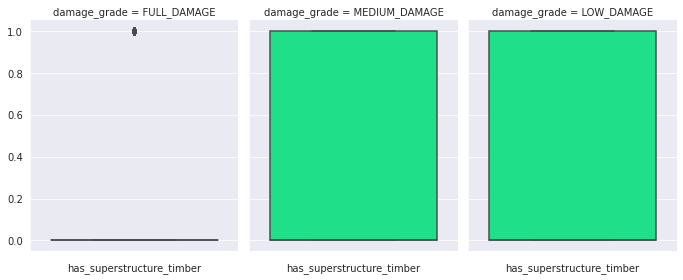

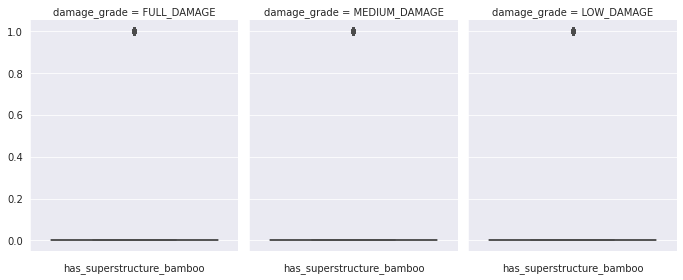

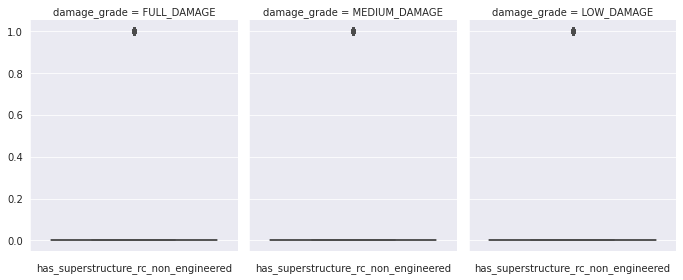

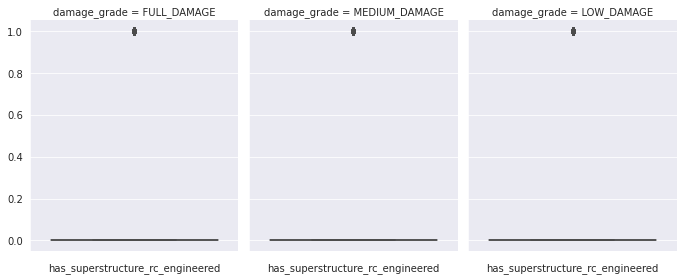

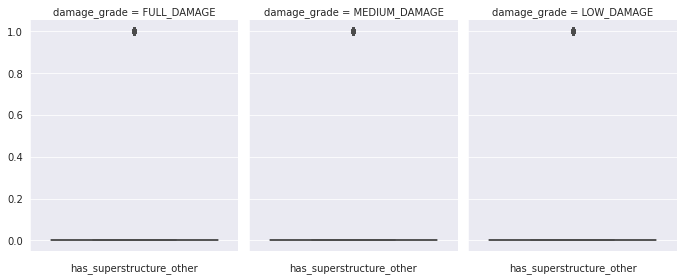

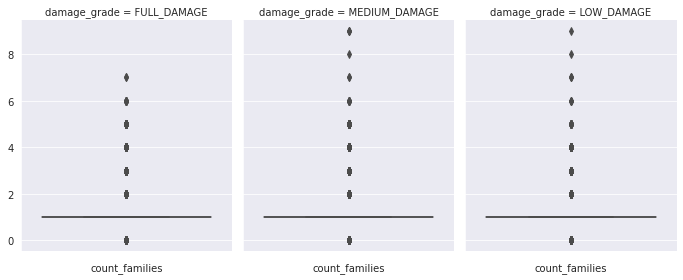

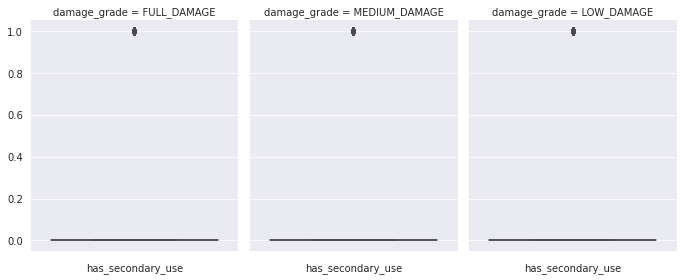

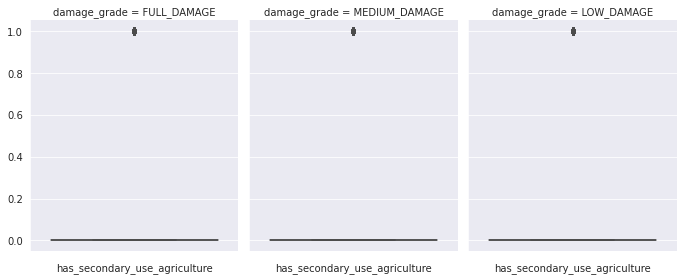

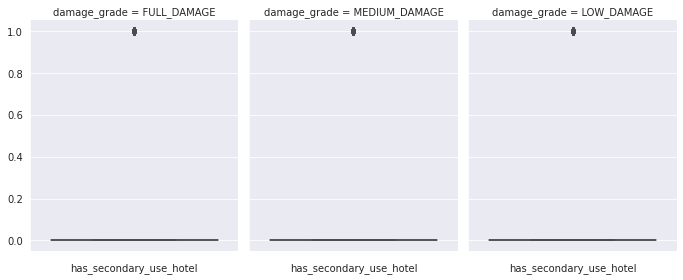

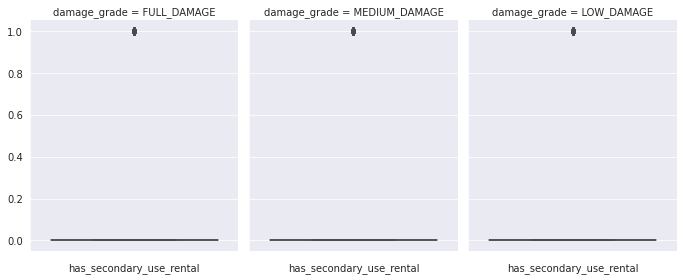

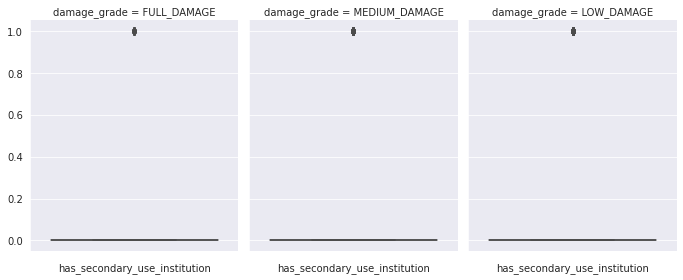

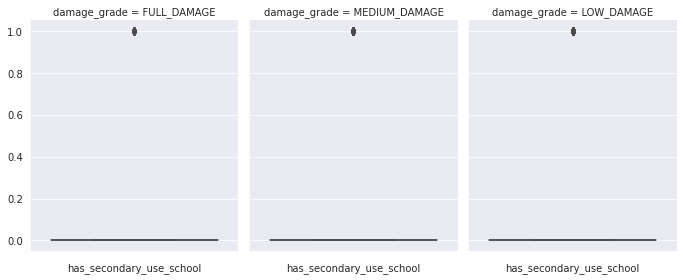

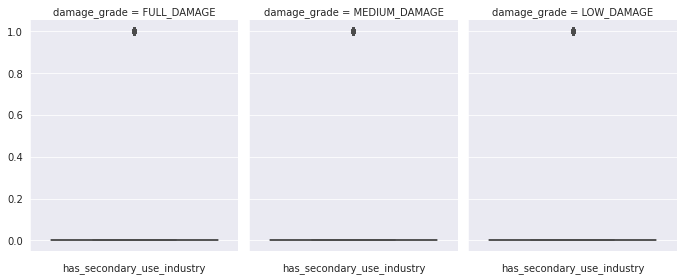

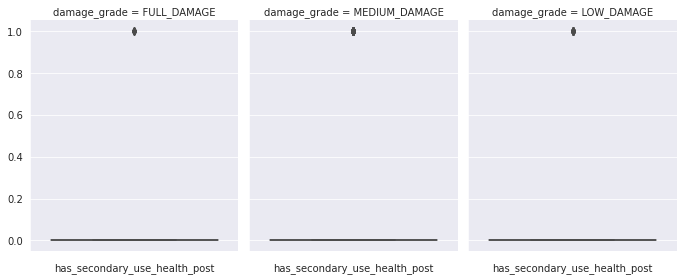

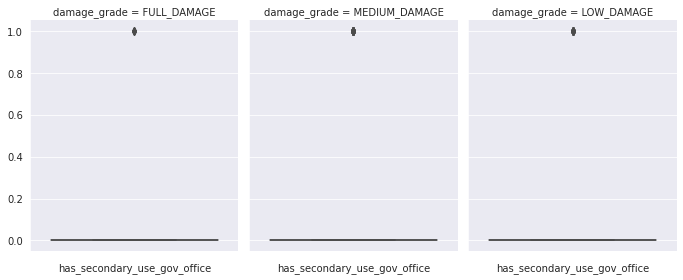

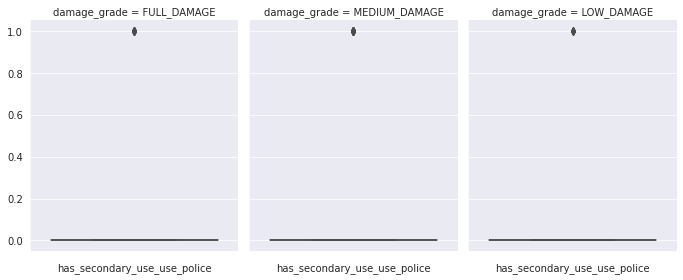

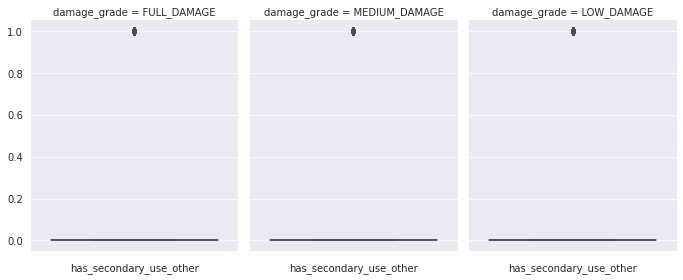

In [31]:
def boxplots(df, target_label):
    """
    df: Pandas DataFrame
    target_label: numpy ndarray or Pandas Series
    """
    cols = df.columns.tolist()
    for col in cols:
      sns.set_style("darkgrid")
      if( df[col].dtypes in [np.int, np.int16, np.int32,
                             np.int64, np.float, np.float16,
                             np.float32, np.float64, np.number] ):
        
        g = sns.FacetGrid(data = df, col = target_label, height = 4, aspect = .8)
        g.map(sns.boxplot, col, orient = 'v', palette = ("gist_rainbow"))

# Call the function
boxplots(df = train_df, target_label = "damage_grade");

**Some Analysis:**
>>> `count_floors_pre_eq:` Is the number of floors in the building before the earthquake.

It actually make sense that buildings with more two floors experienced more damage compared to normal houses; technically this means people who were in these building were in danger. However there's if you look at `damage_grade(1. LOW_DAMAGE)`, they're some outliers that don't make sense. How can the building with more than 3 floors experience a low_damage?

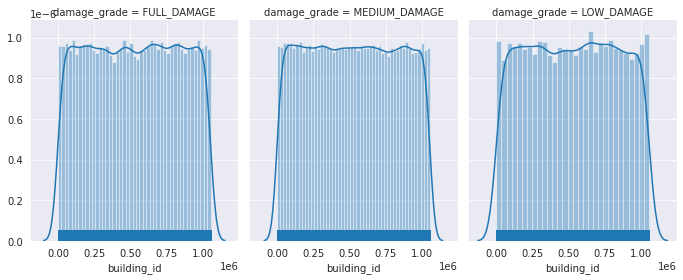

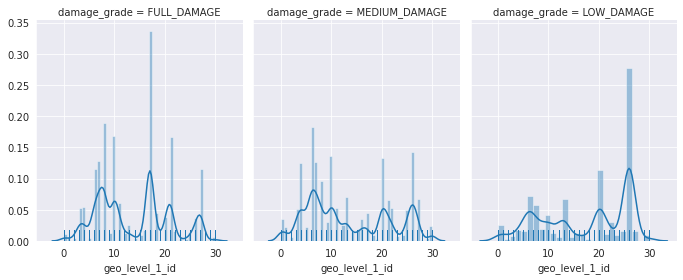

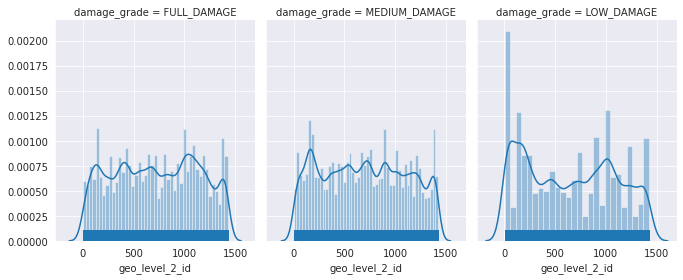

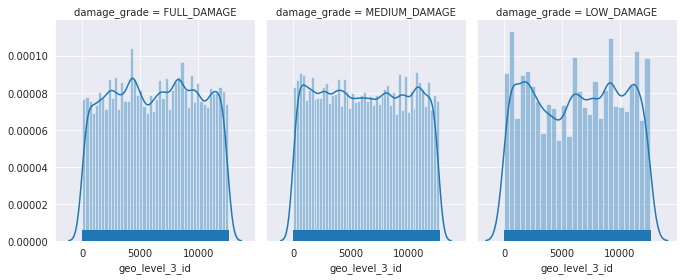

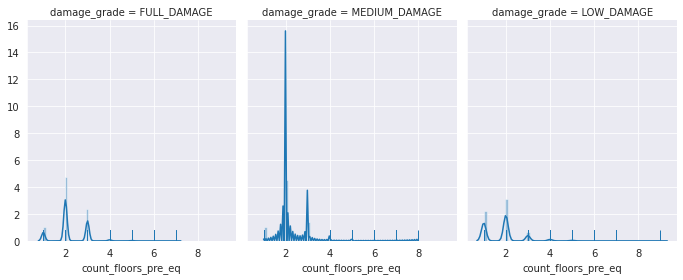

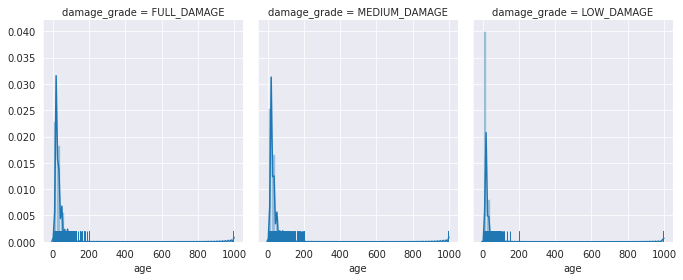

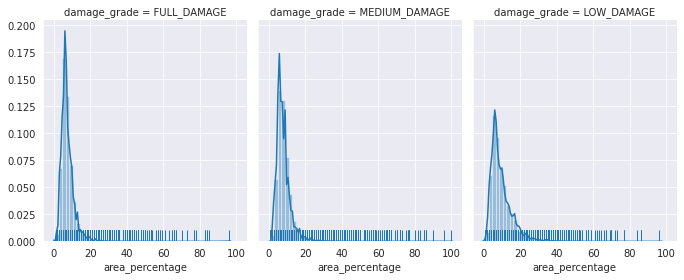

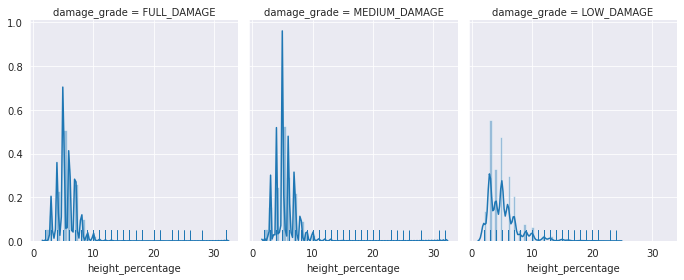

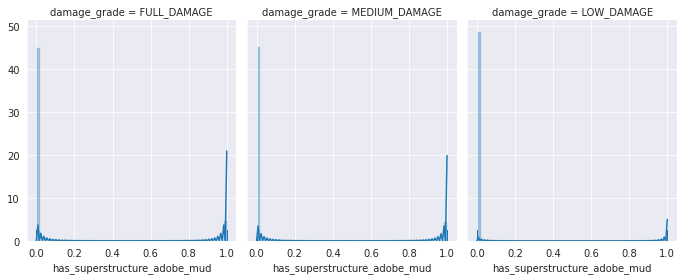

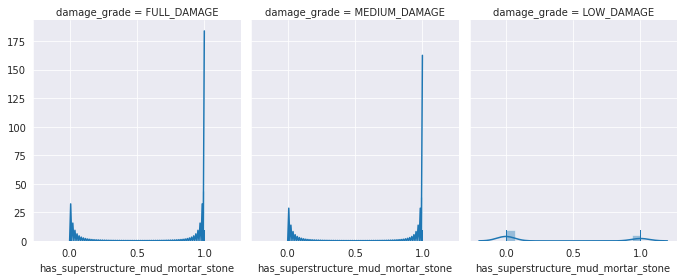

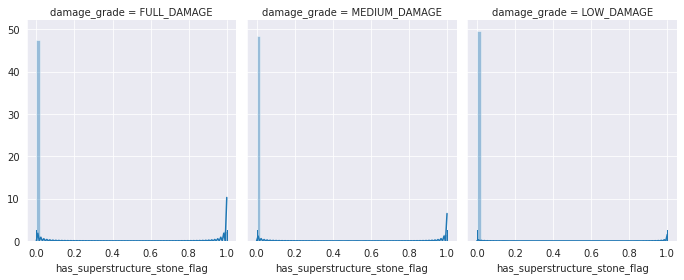

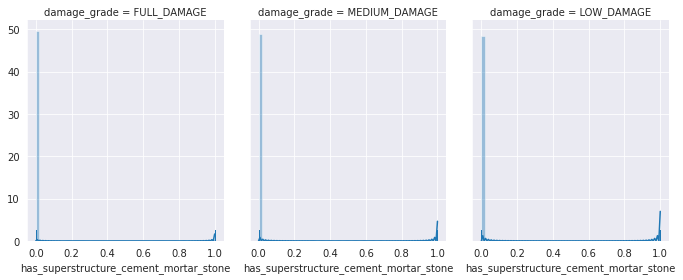

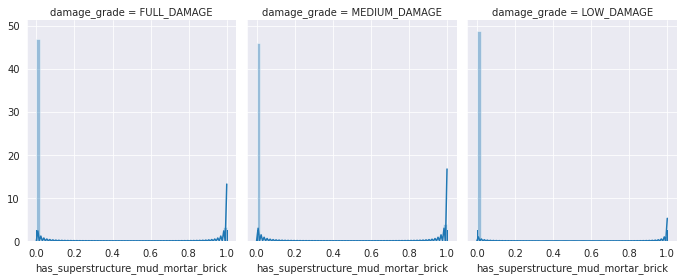

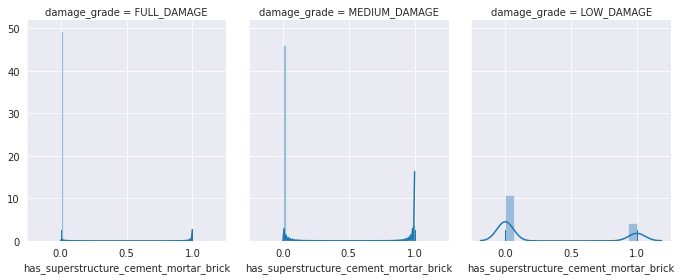

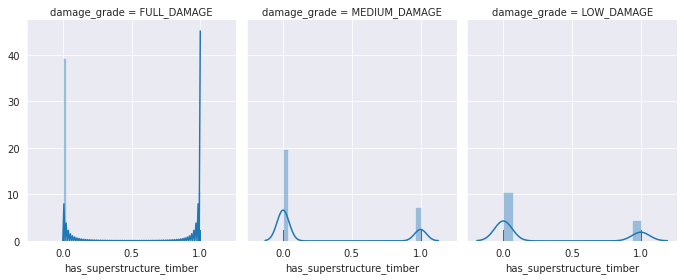

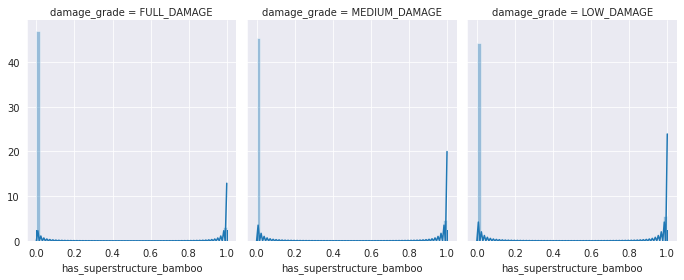

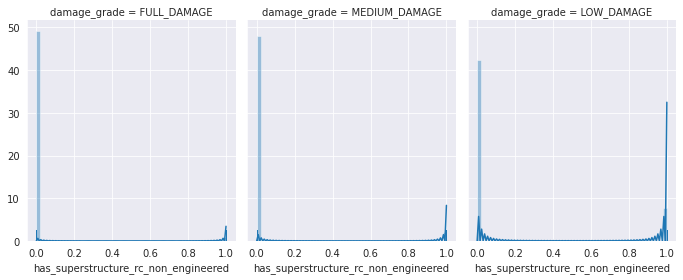

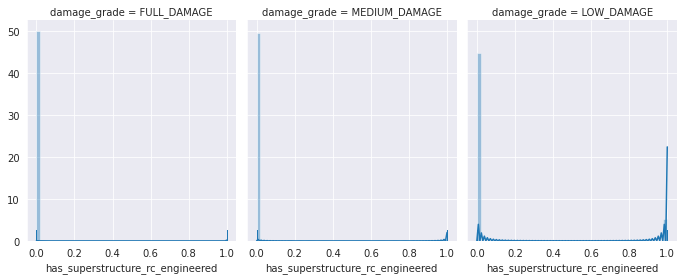

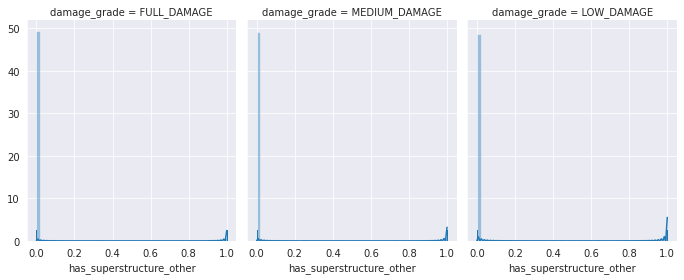

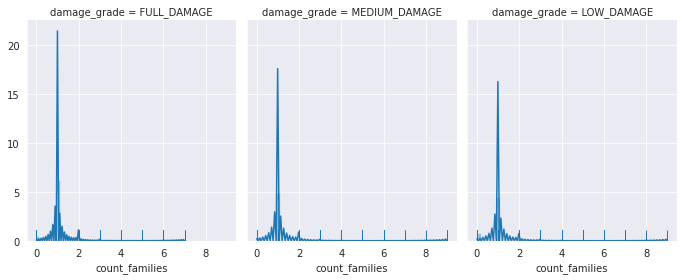

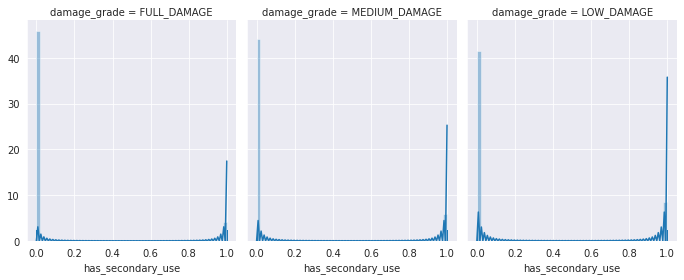

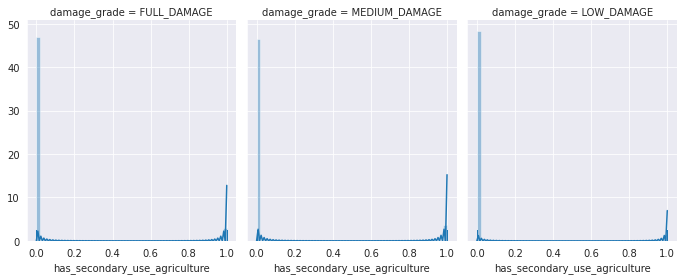

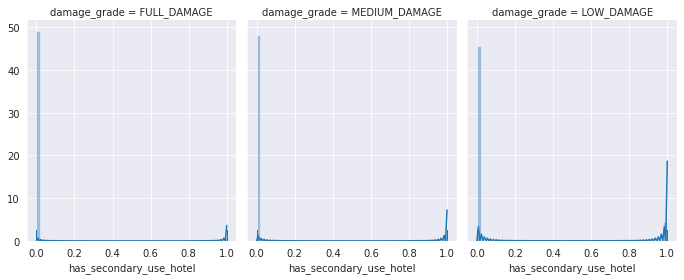

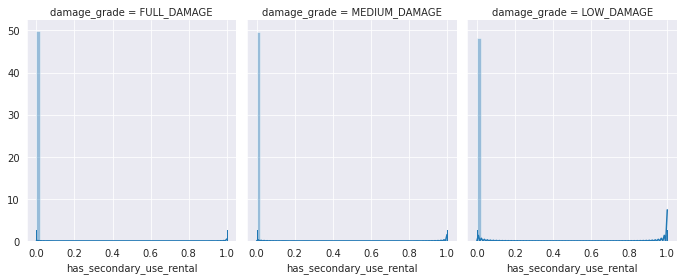

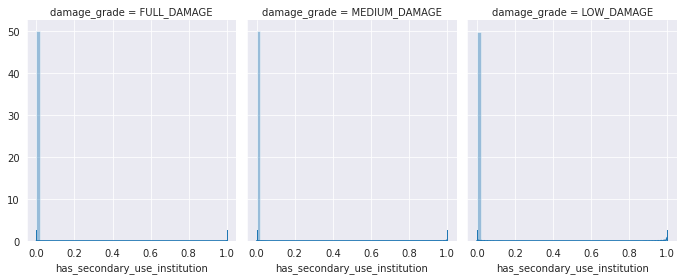

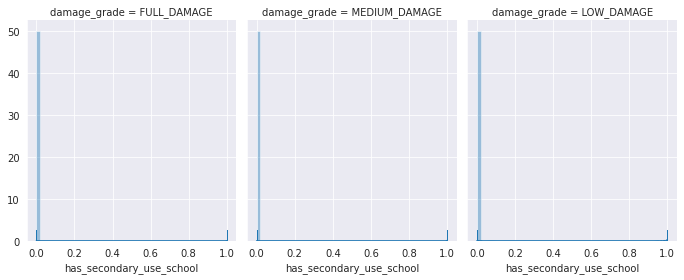

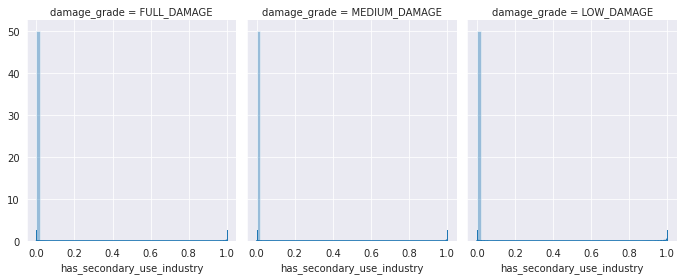

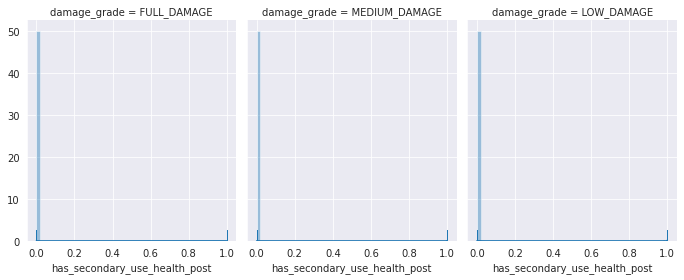

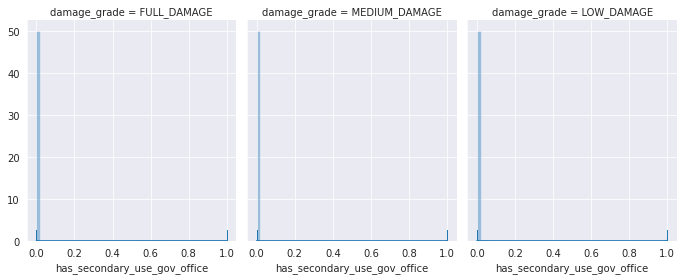

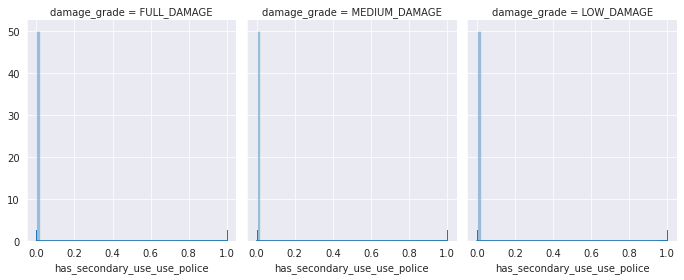

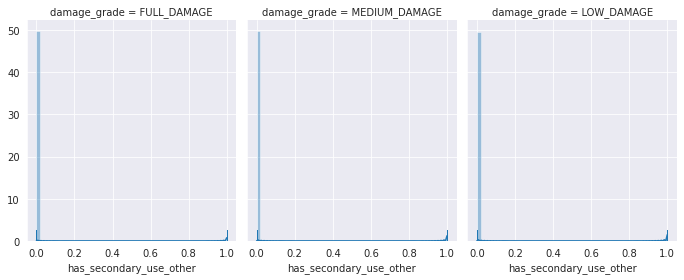

In [32]:
def feats_distributions(df, target_label):
    """
    df: Pandas DataFrame
    target_label: numpy ndarray or Pandas Series
    """
    cols = df.columns.tolist()
    for col in cols:
      sns.set_style("darkgrid")
      if( df[col].dtypes in [np.int, np.int16, np.int32,
                             np.int64, np.float, np.float16,
                             np.float32, np.float64, np.number] ):
        g = sns.FacetGrid(data = df, col = target_label, height = 4, aspect = .8)
        g.map(sns.distplot, col, rug = True)
# Call the function
feats_distributions(df = train_df, target_label = "damage_grade")